# Seasonality analysis

In [6]:
import datetime as dt

import seasonality as ssn

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec

import pandas as pd

import seaborn as sns



# select the symbol to analyze

# symbol = '2B7K.DE'    # iShares MSCI World SRI UCITS ETF EUR (Acc)
# symbol = 'EUNL.DE'    # iShares Core MSCI World UCITS ETF USD (Acc)
# symbol = 'EURUSD=X'   # USD/EUR
# symbol = 'GBPUSD=X'   # GBP/USD
# symbol = 'AUDUSD=X'   # AUD/USD
# symbol = '^ATX'       # Austrian Traded Index in EUR
# symbol = 'ALV.DE'     # Allianz SE
# symbol = 'ADS.DE'     # adidas AG
# symbol = 'EBAY'       # eBay Inc.
# symbol = 'AXP'        # American Express Company
# symbol = 'BTC-USD'    # Bitcoin USD
# symbol = 'ETH-USD'    # Ethereum USD
symbol = '^GSPC'      # S&P 500
# symbol = 'AAPL'       # Apple


# set maximum number of years to analyze
max_num_of_years = 5


analyzer = ssn.Analyzer(symbol, max_num_of_years)
analyzer.calc()


In [7]:
# setup general figure size
generalPlotWidth = 15
generalSubPlotHight = 3

# set number of days for rolling averages for full data plots
rolling_narrow_resolution = 50
rolling_wide_resolution = 200

# activate retina mode
plt.rcParams['figure.dpi'] = 200

# configure theme and style
sns.set_theme('paper')
sns.set_style('darkgrid')


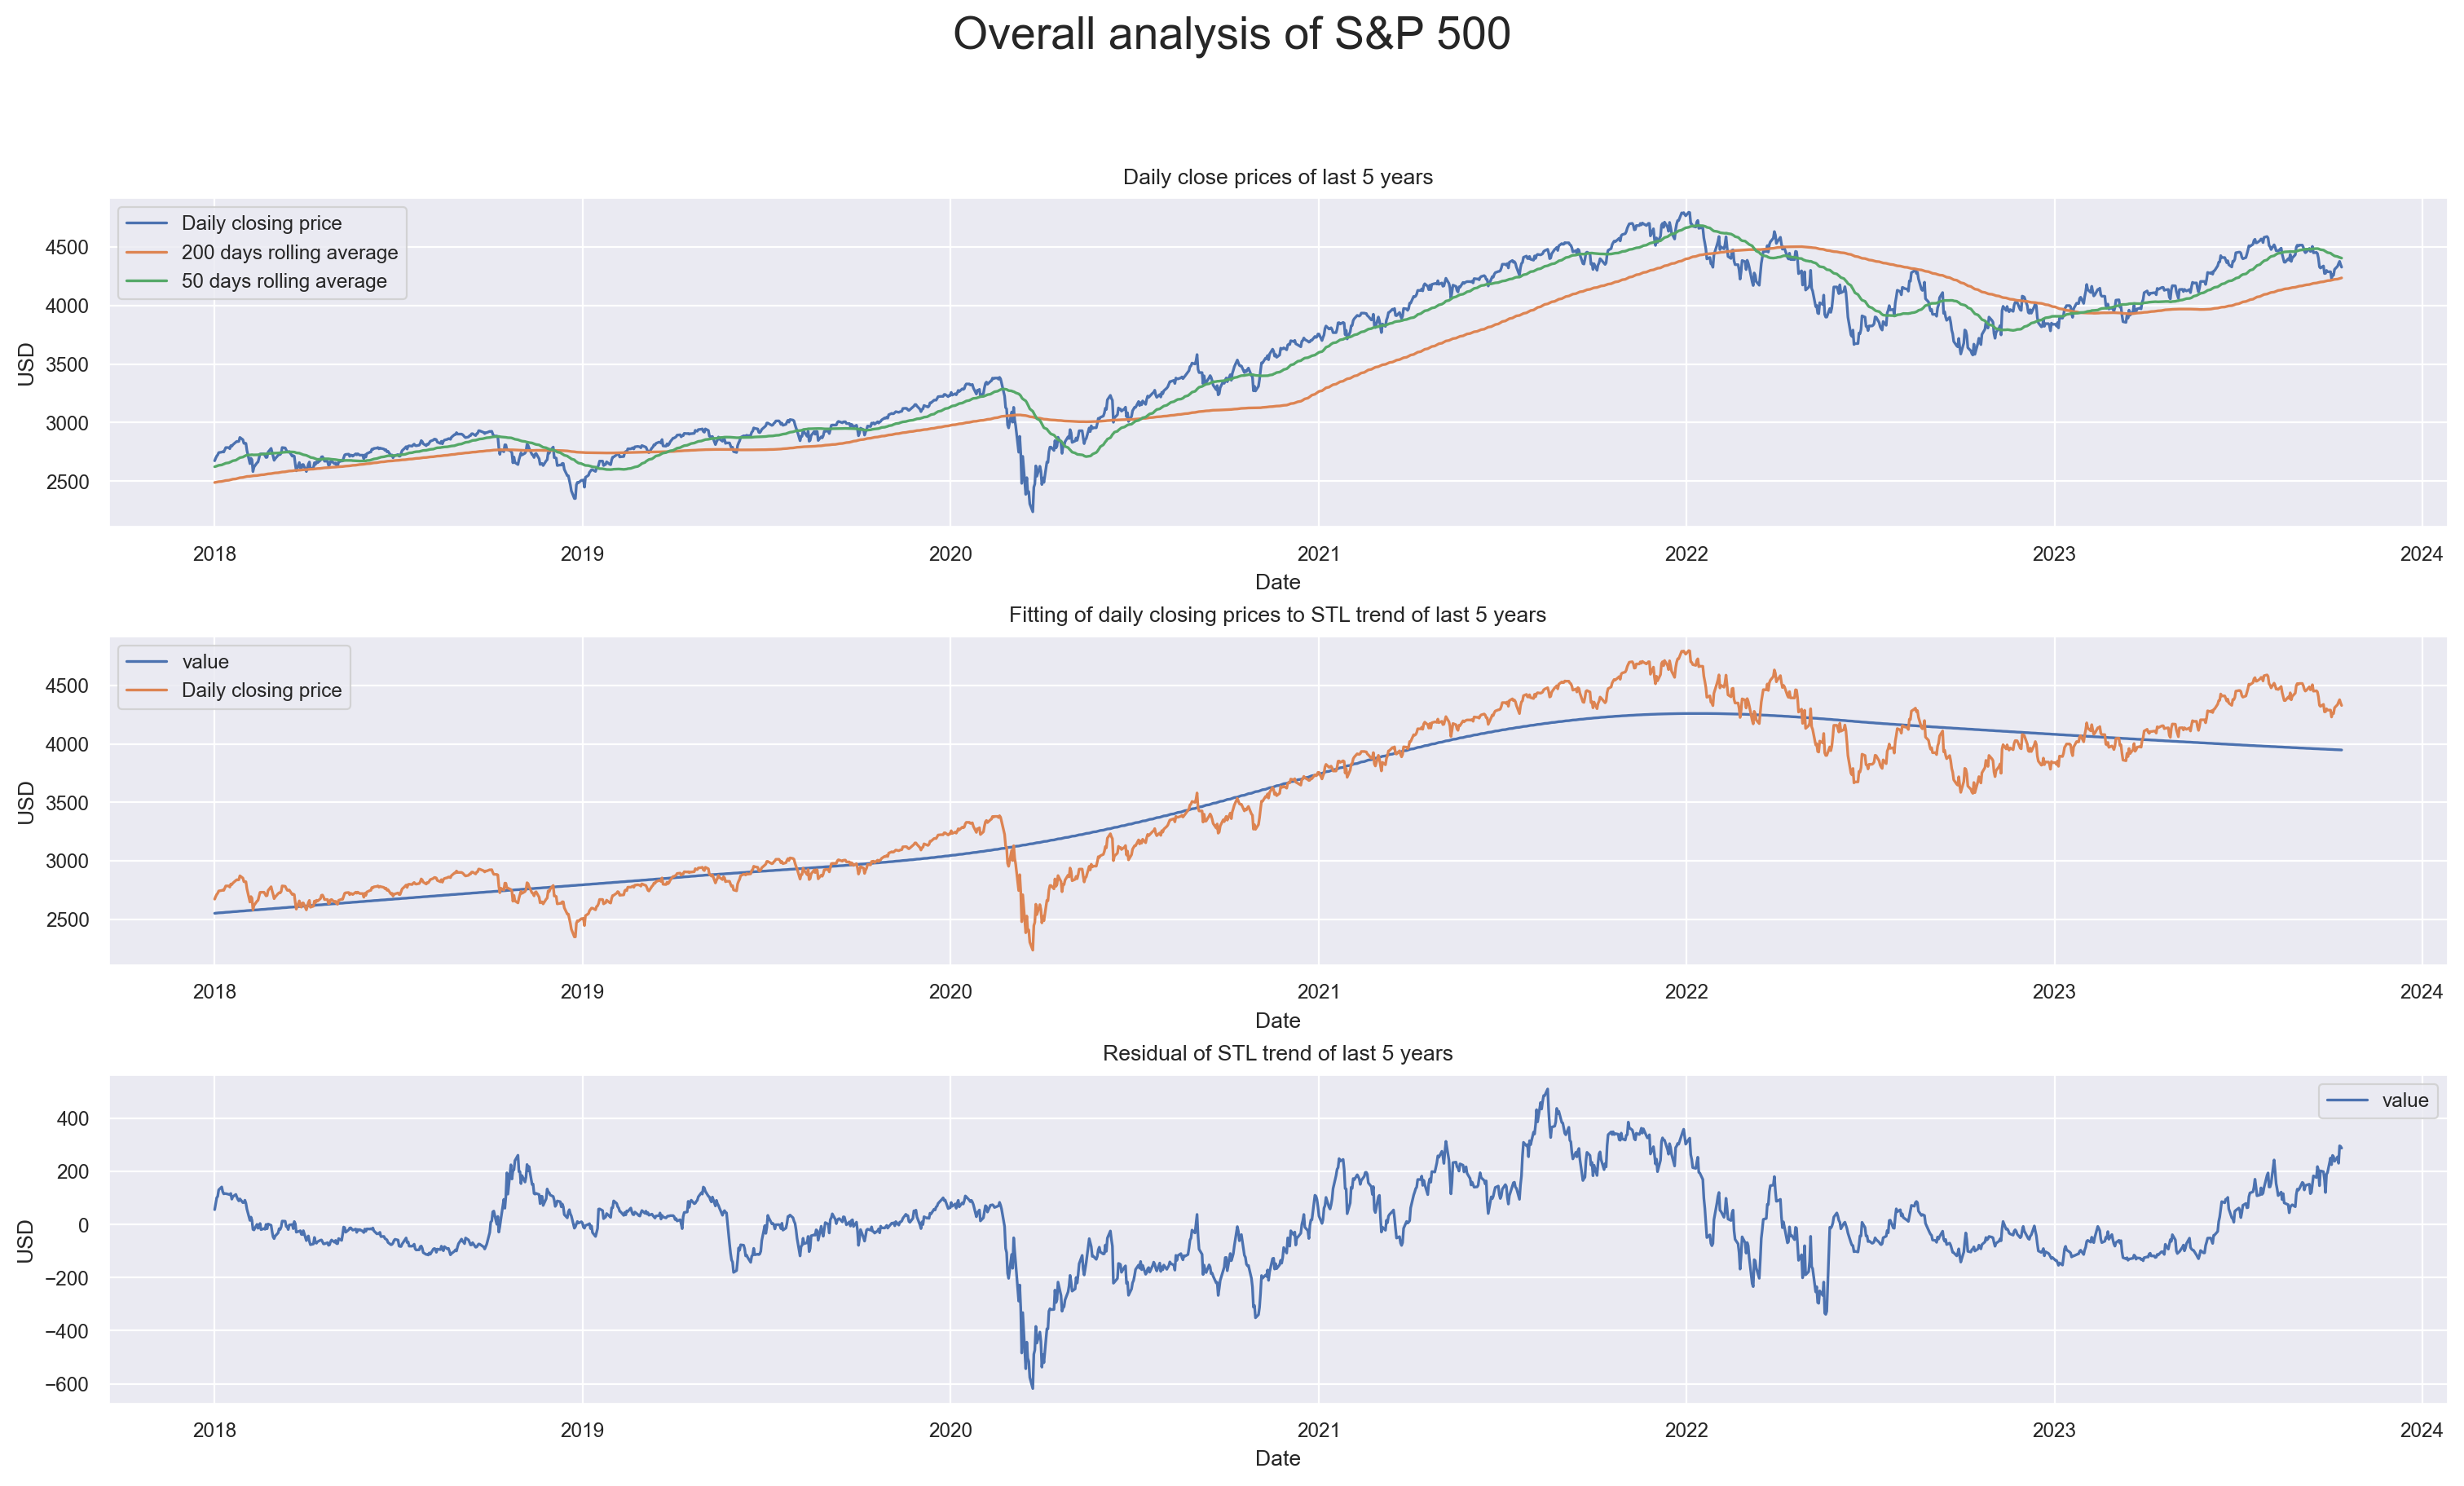

In [8]:

numSubPlots = 3
fig, axs = plt.subplots(numSubPlots, 1, figsize=(generalPlotWidth, generalSubPlotHight*numSubPlots), layout="constrained")
fig.suptitle(f'Overall analysis of {analyzer.ticker.info["longName"]}\n\n', fontsize=20)

currentAxis = 0

# Plot overall closing prices of last x years
overallDf = pd.DataFrame(data=analyzer.df)
overallDf[f'{rolling_wide_resolution} days rolling average'] = overallDf['Close'].rolling(rolling_wide_resolution).mean()
overallDf[f'{rolling_narrow_resolution} days rolling average'] = overallDf['Close'].rolling(rolling_narrow_resolution).mean()
overallDf.rename(columns={'Close':'Daily closing price'}, inplace=True)
overallDf = overallDf[analyzer.rangeMaxYrs.min():pd.to_datetime('today')]
sns.lineplot(data=overallDf, dashes=False, ax=axs[currentAxis], legend='full')
axs[currentAxis].set_title(f'Daily close prices of last {analyzer.rangeNumOfYears} years')
axs[currentAxis].set_ylabel(analyzer.ticker.info['currency'])
currentAxis += 1


# Plot overall closing prices of last x years with STL trend
overallDf = pd.DataFrame(data=analyzer.trendDecompDf)
overallDf = overallDf[analyzer.rangeMaxYrs.min():pd.to_datetime('today')]
overallDf['Daily closing price'] = analyzer.df[analyzer.rangeMaxYrs.min():pd.to_datetime('today')]['Close']
sns.lineplot(data=overallDf, dashes=False, ax=axs[currentAxis], legend='full')
axs[currentAxis].set_title(f'Fitting of daily closing prices to STL trend of last {analyzer.rangeNumOfYears} years')
axs[currentAxis].set_ylabel(analyzer.ticker.info['currency'])
currentAxis += 1


# Plot overall STL residual of last x years with STL trend
overallDf = pd.DataFrame(data=analyzer.residDecompDf)
sns.lineplot(data=overallDf, dashes=False, ax=axs[currentAxis], legend='full')
axs[currentAxis].set_title(f'Residual of STL trend of last {analyzer.rangeNumOfYears} years')
axs[currentAxis].set_ylabel(analyzer.ticker.info['currency'])
currentAxis += 1

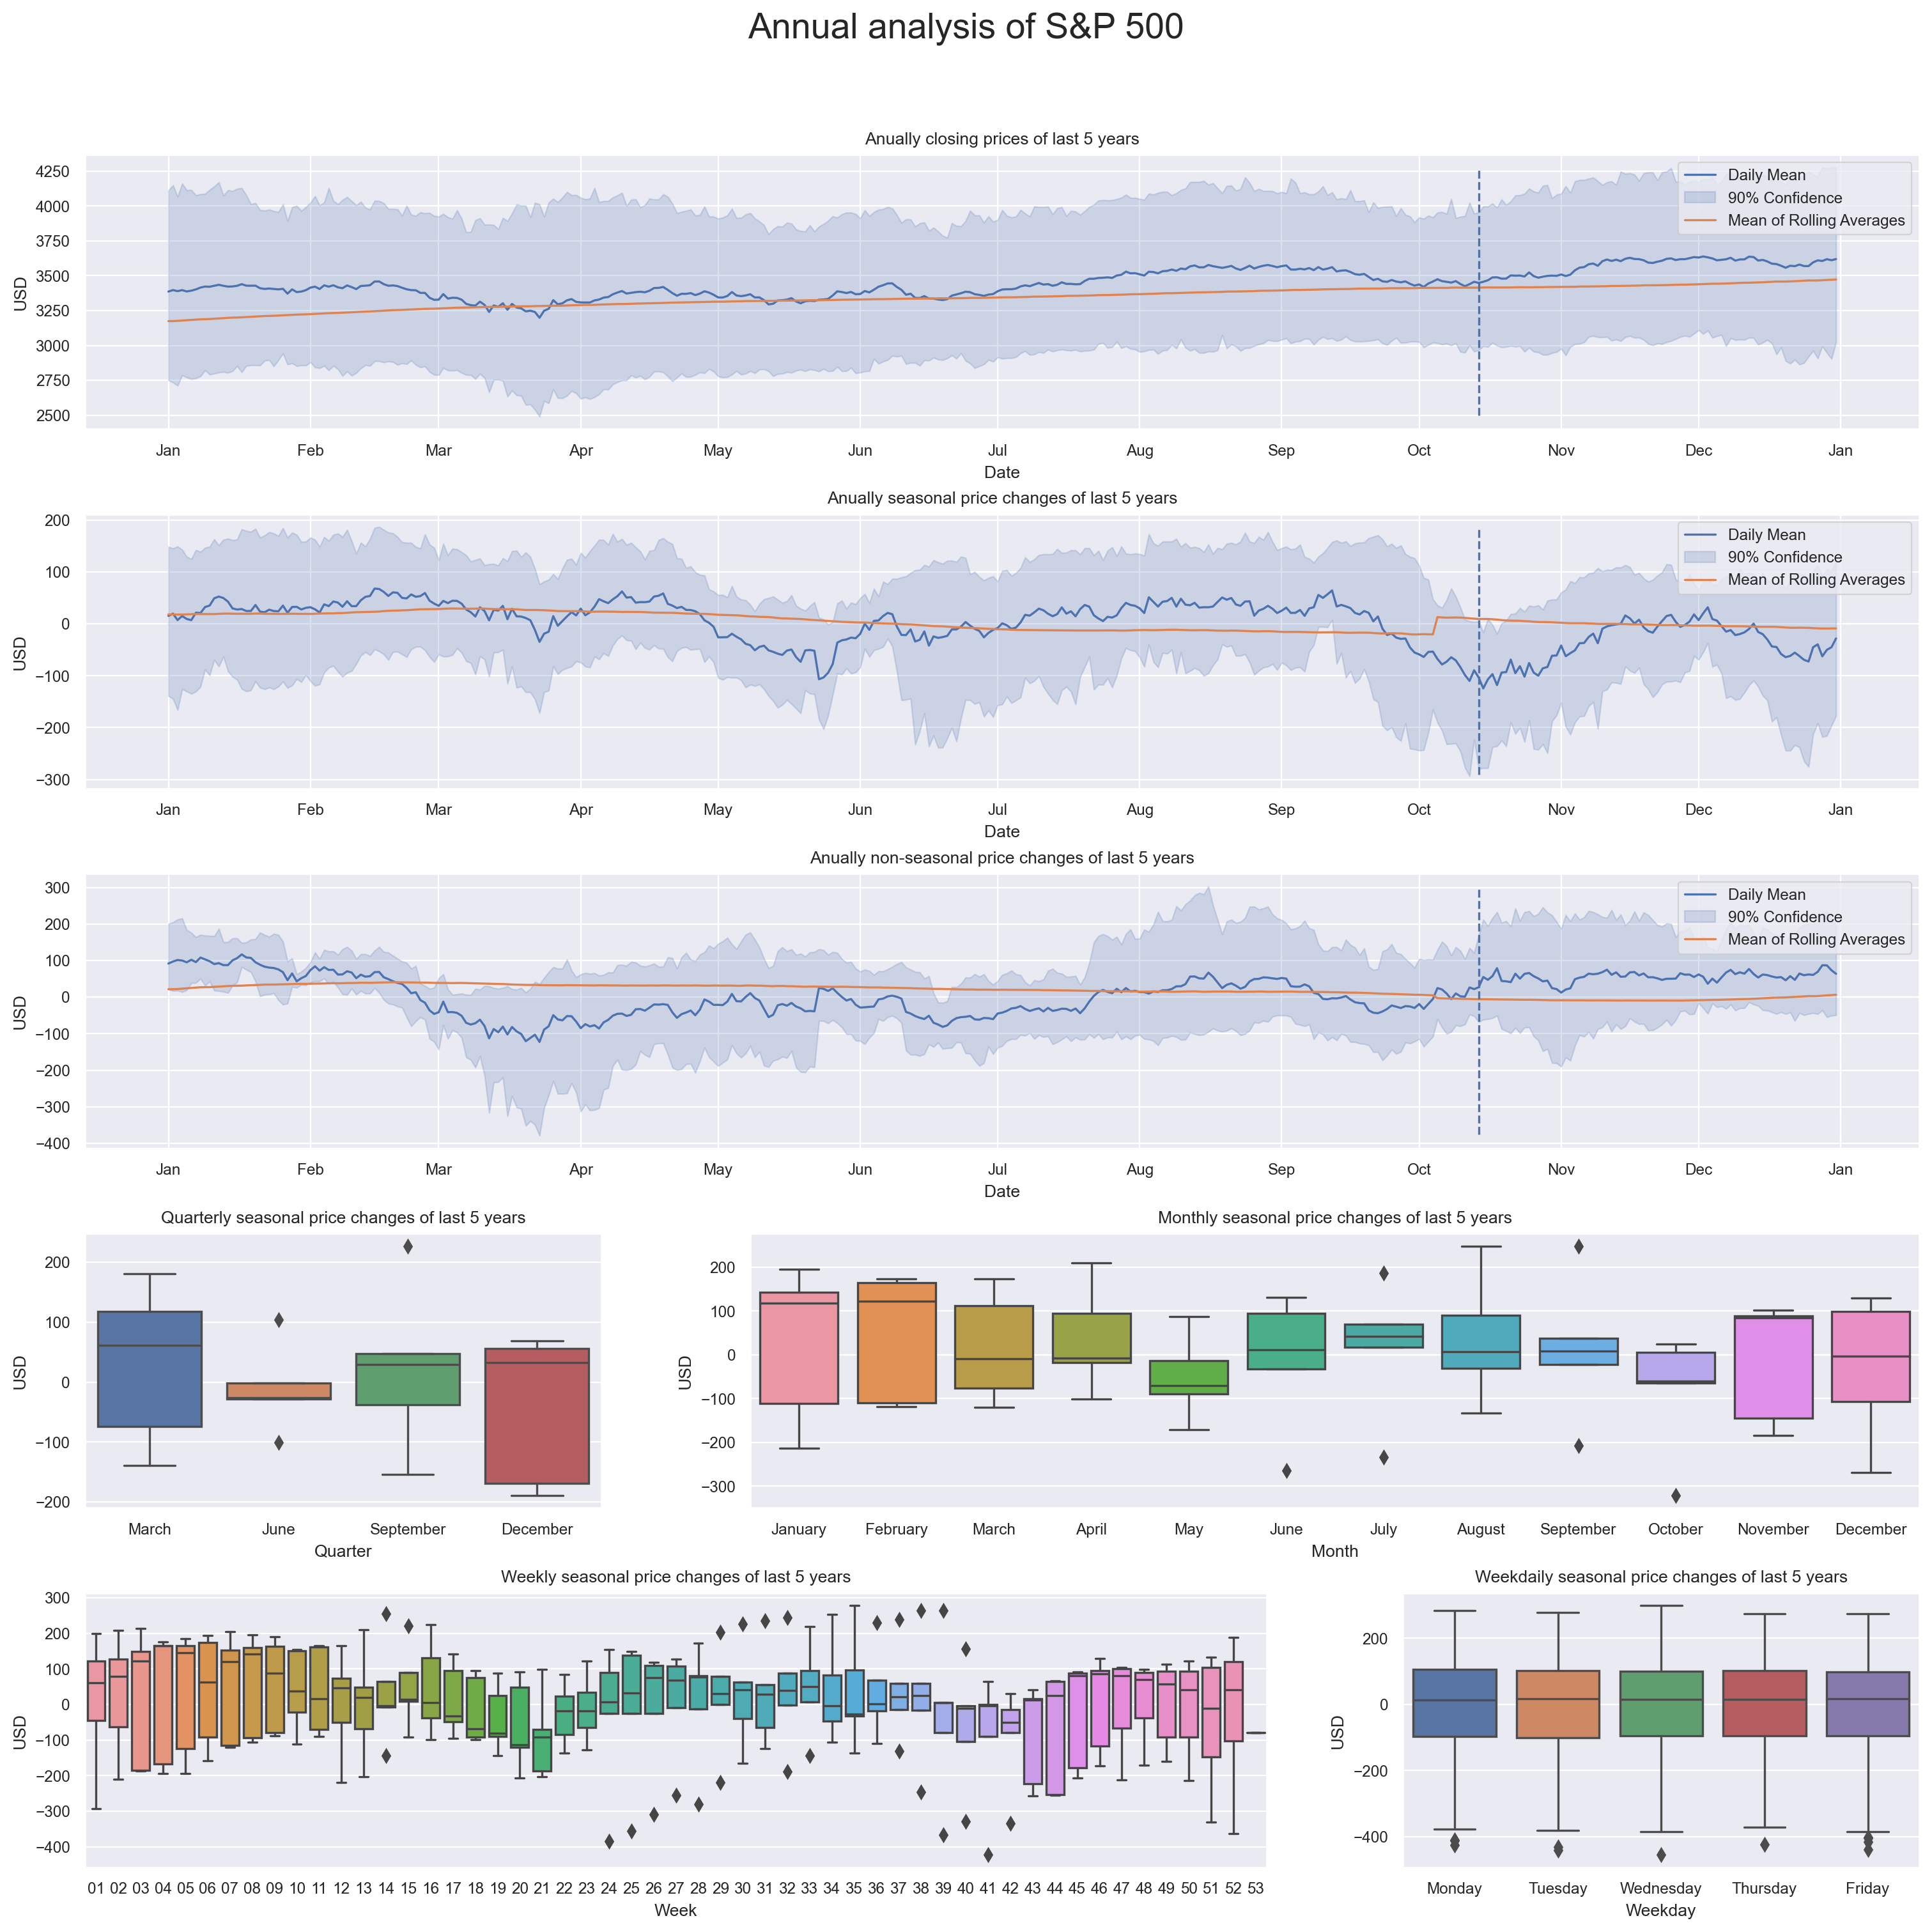

In [9]:
axs = []
numSubPlots = 5

fig = plt.figure(layout="constrained", figsize=(generalPlotWidth, generalSubPlotHight*numSubPlots))
gs = GridSpec(5, 3, figure=fig)
sns.set_theme('paper')
fig.suptitle(f'Annual analysis of {analyzer.ticker.info["longName"]}\n\n', fontsize=20)

currentAxis = 0

axs.append(fig.add_subplot(gs[0, :]))   # add plot over full line
# Plot annual closing prices with confidence band
sns.lineplot(data=analyzer.annualDf, x='Day', y='Close', ax=axs[currentAxis], sort=True)
sns.lineplot(data=analyzer.annualDf, x='Day', y='rolling average', ax=axs[currentAxis], sort=True, errorbar=None)
axs[currentAxis].xaxis.set_major_locator(mdates.MonthLocator())
axs[currentAxis].axvline(f'{"{:02d}".format(dt.date.today().month)}-{"{:02d}".format(dt.date.today().day)}', ymin=0.05, ymax=0.95, linestyle='dashed')
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_xlabel('Date')
axs[currentAxis].set_title(f'Anually closing prices of last {analyzer.rangeNumOfYears} years')
axs[currentAxis].legend(labels=['Daily Mean', '90% Confidence', 'Mean of Rolling Averages'])
axs[currentAxis].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
currentAxis += 1


axs.append(fig.add_subplot(gs[1, :]))   # add plot over full line
# Plot annual seasonal prices with confidence band
sns.lineplot(data=analyzer.annunalSeasonalDecompDf, ax=axs[currentAxis], x='Day', y='value')
sns.lineplot(data=analyzer.annunalSeasonalDecompDf, x='Day', y='rolling average', ax=axs[currentAxis], sort=True, errorbar=None)
axs[currentAxis].xaxis.set_major_locator(mdates.MonthLocator())
axs[currentAxis].axvline(f'{"{:02d}".format(dt.date.today().month)}-{"{:02d}".format(dt.date.today().day)}', ymin=0.05, ymax=0.95, linestyle='dashed')
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_xlabel('Date')
axs[currentAxis].set_title(f'Anually seasonal price changes of last {analyzer.rangeNumOfYears} years')
axs[currentAxis].legend(labels=['Daily Mean', '90% Confidence', 'Mean of Rolling Averages'])
axs[currentAxis].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
currentAxis += 1


axs.append(fig.add_subplot(gs[2, :]))   # add plot over full line
# Plot annual residual prices with confidence band
sns.lineplot(data=analyzer.annunalResidDecompDf, ax=axs[currentAxis], x='Day', y='value')
sns.lineplot(data=analyzer.annunalResidDecompDf, x='Day', y='rolling average', ax=axs[currentAxis], sort=True, errorbar=None)
axs[currentAxis].xaxis.set_major_locator(mdates.MonthLocator())
axs[currentAxis].axvline(f'{"{:02d}".format(dt.date.today().month)}-{"{:02d}".format(dt.date.today().day)}', ymin=0.05, ymax=0.95, linestyle='dashed')
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_xlabel('Date')
axs[currentAxis].set_title(f'Anually non-seasonal price changes of last {analyzer.rangeNumOfYears} years')
axs[currentAxis].legend(labels=['Daily Mean', '90% Confidence', 'Mean of Rolling Averages'])
axs[currentAxis].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
currentAxis += 1


axs.append(fig.add_subplot(gs[3, 0]))
# Plot quarterly seasonal prices
sns.boxplot(data=analyzer.quarterlySeasonalDecompDf, x='Quarter', y='value', ax=axs[currentAxis])
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_title(f'Quarterly seasonal price changes of last {analyzer.rangeNumOfYears} years')
currentAxis += 1

axs.append(fig.add_subplot(gs[3, 1:]))
# Plot monthly seasonal prices
sns.boxplot(data=analyzer.monthlySeasonalDecompDf, x='Month', y='value', ax=axs[currentAxis])
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_title(f'Monthly seasonal price changes of last {analyzer.rangeNumOfYears} years')
currentAxis += 1

axs.append(fig.add_subplot(gs[4, :-1]))
# Plot weekly seasonal prices
sns.boxplot(data=analyzer.weeklySeasonalDecompDf, x='Week', y='value', ax=axs[currentAxis])
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_title(f'Weekly seasonal price changes of last {analyzer.rangeNumOfYears} years')
currentAxis += 1

axs.append(fig.add_subplot(gs[4, 2]))
# Plot weekdaily seasonal prices
sns.boxplot(data=analyzer.weekdailySeasonalDecompDf, x='Weekday', y='value', ax=axs[currentAxis])
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_title(f'Weekdaily seasonal price changes of last {analyzer.rangeNumOfYears} years')
currentAxis += 1
